# Import necessary libraries

In [1]:
from pathlib import Path
from anomalib.data.utils import read_image
from anomalib.deploy import TorchInferencer


In [2]:
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType
from anomalib.data.utils import TestSplitMode

datamodule = Folder( 
    root=Path.cwd() / "battery_discharging",
    normal_dir="normal_masked",
    image_size=(80, 60),
    test_split_mode=TestSplitMode.SYNTHETIC,
    task=TaskType.CLASSIFICATION,

)

datamodule.setup() # Split the data to train/val/test/prediction sets. 

datamodule.prepare_data() # Create train/val/test/predic dataloaders 

i, data = next(enumerate(datamodule.val_dataloader()))

print(data.keys())

dict_keys(['image_path', 'label', 'image'])


In [3]:
i, data = next(enumerate(datamodule.val_dataloader()))

In [4]:
# Check image size
print(data["image"].shape)

torch.Size([32, 3, 80, 60])


In [5]:
from anomalib.models import Padim

model = Padim(
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
    input_size=(80, 60)
)

c:\Users\PEE1UL\AppData\Local\miniconda3\envs\ganomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [6]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod 

from anomalib.utils.callbacks import ( 

    MetricsConfigurationCallback, 

    MinMaxNormalizationCallback, 

    PostProcessingConfigurationCallback, 

) 

from anomalib.utils.callbacks.export import ExportCallback, ExportMode
from pytorch_lightning.callbacks import ModelCheckpoint 

callbacks = [ 

    MetricsConfigurationCallback( 

        task=TaskType.CLASSIFICATION, 

        image_metrics=["AUROC"], 

    ), 

    ModelCheckpoint( 

        mode="max", 

        monitor="image_AUROC", 

    ), 

    PostProcessingConfigurationCallback( 

        normalization_method=NormalizationMethod.MIN_MAX, 

        threshold_method=ThresholdMethod.ADAPTIVE, 

    ), 

    MinMaxNormalizationCallback(), 

    ExportCallback( 

        input_size=(80, 60), 

        dirpath=str(Path.cwd()), 

        filename="model", 

        export_mode=ExportMode.TORCH, 

    ), 

]

In [7]:
from pytorch_lightning import Trainer

trainer = Trainer(
    callbacks=callbacks,
    accelerator= "cpu",
    auto_scale_batch_size= False,
    check_val_every_n_epoch= 1,
    devices= 1,
    gpus= None,
    max_epochs= 1,
    num_sanity_val_steps= 0,
    val_check_interval= 1.0,
)

trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Missing logger folder: c:\Users\PEE1UL\Desktop\SemiSupervisedAlgorithmBatteryDischargingV3\lightning_logs
c:\Users\PEE1UL\AppData\Local\miniconda3\envs\ganomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\PEE1UL\AppData\Local\miniconda3\envs\ganomaly\lib\site-packages\pytorch_lightning\core\optimizer.py:184: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  "`LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer",

  | Name                  | Type             

Training: 0it [00:00, ?it/s]

c:\Users\PEE1UL\AppData\Local\miniconda3\envs\ganomaly\lib\site-packages\pytorch_lightning\loops\optimization\optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


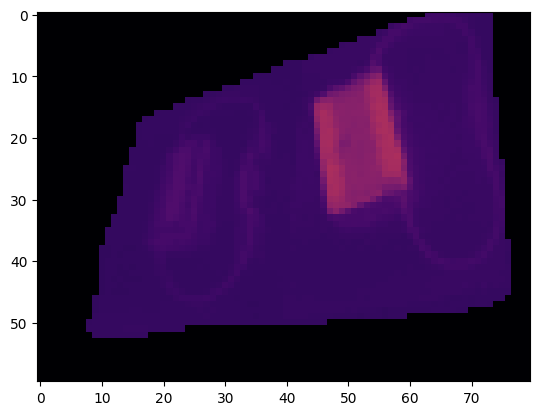

In [8]:
from matplotlib import pyplot as plt

image_path = "./battery_discharging/normal_masked/DS1_N12_20240902_0212_112046783_INPUT_TEST_OK_CAM2_thermal.png"
image = read_image(path=image_path)
plt.imshow(image)

In [9]:
torch_model_path = r"C:\Users\PEE1UL\Desktop\SemiSupervisedAlgorithmBatteryDischargingV3\weights\torch\model.pt"
metadata_path = r"C:\Users\PEE1UL\Desktop\SemiSupervisedAlgorithmBatteryDischargingV3\weights\onnx\metadata.json"

print(torch_model_path, metadata_path)

inferencer = TorchInferencer(

    # Pass the config file to the inferencer in case

    # you are making modification to your training process 

    # through your production system, otherwise keep the API use 

    path=torch_model_path, # Path to the OpenVINO IR model. 
    device="cpu", # We would like to run it on an Intel CPU. 

)

C:\Users\PEE1UL\Desktop\SemiSupervisedAlgorithmBatteryDischargingV3\weights\torch\model.pt C:\Users\PEE1UL\Desktop\SemiSupervisedAlgorithmBatteryDischargingV3\weights\onnx\metadata.json


In [10]:
print(image.shape)
predictions = inferencer.predict(image=image)

(60, 80, 3)


In [11]:
print(predictions.image)

[[[0 0 3]
  [0 0 3]
  [0 0 3]
  ...
  [0 0 3]
  [0 0 3]
  [0 0 3]]

 [[0 0 3]
  [0 0 3]
  [0 0 3]
  ...
  [0 0 3]
  [0 0 3]
  [0 0 3]]

 [[0 0 3]
  [0 0 3]
  [0 0 3]
  ...
  [0 0 3]
  [0 0 3]
  [0 0 3]]

 ...

 [[0 0 3]
  [0 0 3]
  [0 0 3]
  ...
  [0 0 3]
  [0 0 3]
  [0 0 3]]

 [[0 0 3]
  [0 0 3]
  [0 0 3]
  ...
  [0 0 3]
  [0 0 3]
  [0 0 3]]

 [[0 0 3]
  [0 0 3]
  [0 0 3]
  ...
  [0 0 3]
  [0 0 3]
  [0 0 3]]]


In [12]:
print(predictions.pred_score)

0.4350785310415853


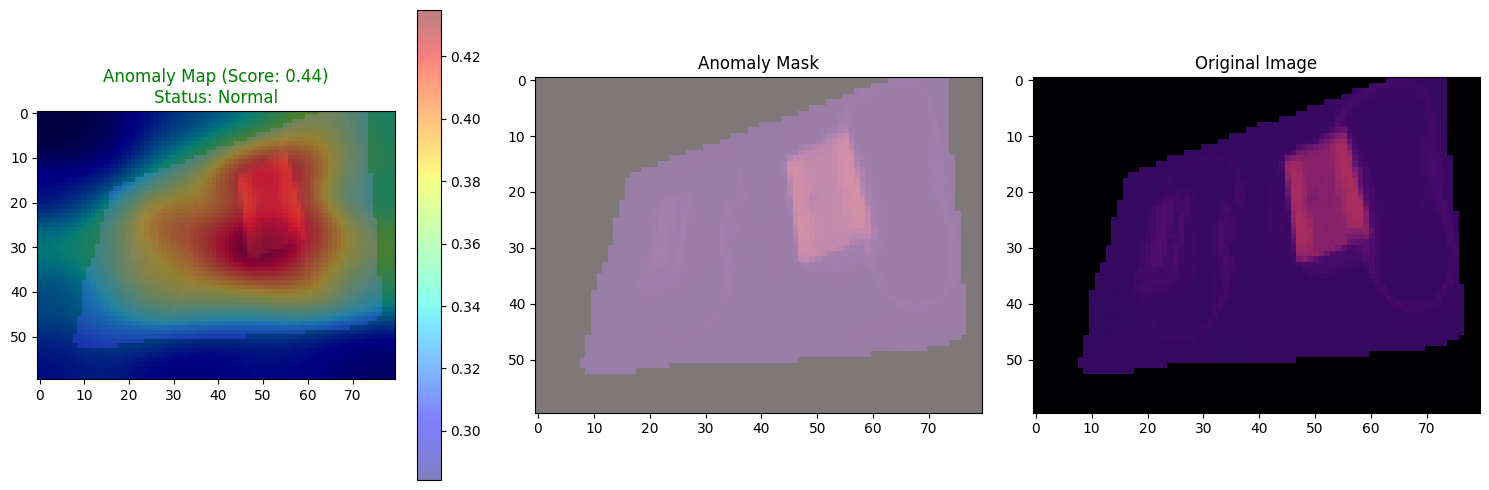

In [13]:
import matplotlib.pyplot as plt

image = predictions.image
anomaly_map = predictions.anomaly_map
score = predictions.pred_score
mask = predictions.pred_mask

# Function to visualize the predictions
def visualize_predictions(image, anomaly_map, score, mask, threshold=0.65, alpha=0.5, colormap='jet'):
    """
    Visualize the image, anomaly map, prediction score, and mask.
    Display 'Anomaly' in red if score exceeds the threshold, otherwise display 'Normal' in green.

    Args:
        image (np.ndarray): The input image.
        anomaly_map (np.ndarray): The anomaly map.
        score (float): The prediction score.
        mask (np.ndarray): The binary mask of the anomalies.
        threshold (float): Threshold to classify as anomaly or normal.
        alpha (float): Transparency level for the overlay.
        colormap (str): Colormap to use for the anomaly map.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the original image with anomaly map overlay
    axs[0].imshow(image, cmap='gray')
    anomaly_overlay = axs[0].imshow(anomaly_map, cmap=colormap, alpha=alpha)
    fig.colorbar(anomaly_overlay, ax=axs[0])
    
    # Determine the text and color based on the score
    if score > threshold:
        status_text = 'Anomaly'
        color = 'red'
    else:
        status_text = 'Normal'
        color = 'green'
    
    axs[0].set_title(f'Anomaly Map (Score: {score:.2f})\nStatus: {status_text}', color=color)
    
    # Display the mask
    axs[1].imshow(image, cmap='gray')
    axs[1].imshow(mask, cmap='Reds', alpha=alpha)
    axs[1].set_title('Anomaly Mask')
    
    # Display the original image
    axs[2].imshow(image, cmap='gray')
    axs[2].set_title('Original Image')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(image, anomaly_map, score, mask)  


In [14]:
import glob

# Set the path to the test image directory
test_image_directory = "./battery_discharging/test/masked/*.png"

# Get a list of all image paths in the directory
test_image_paths = glob.glob(test_image_directory)

# Create an empty list to store prediction scores
prediction_scores = []

# Iterate over each image and run the model predictions
for image_path in test_image_paths:

    #print(f"Processing image: {image_path}")  # Debugging print

    # Read the image
    image = read_image(path=image_path)
    
    # Run predictions using the inferencer
    predictions = inferencer.predict(image=image)
    
    # Extract prediction score
    score = predictions.pred_score
    
    # Append the score to the list
    prediction_scores.append(score)

    #Optional: Extract prediction results
    image = predictions.image
    anomaly_map = predictions.anomaly_map
    score = predictions.pred_score
    mask = predictions.pred_mask
    
    #Visualize the predictions
    #visualize_predictions(image, anomaly_map, score, mask)

# Print the collected prediction scores as an array
print("Prediction Scores Array:", prediction_scores)

# Count how many scores are above the defined threshold
count_above_threshold = sum(score > 0.65 for score in prediction_scores)

# Print the total count
print(f"Number of prediction scores above 0.65: {count_above_threshold}")

Prediction Scores Array: [0.7474890716872526, 0.8592843313648901, 0.8347225842689551, 0.633169774048159, 1.0, 0.7042470476811338, 1.0, 0.6885965523695506, 1.0, 0.6301767706298009, 1.0, 0.8139101857890552, 0.570067672419211, 1.0, 0.8620453842656877, 0.7012367553746275, 0.9113252817729675, 1.0, 1.0, 0.9904833118723366, 0.984136229226173, 1.0, 0.7481749341045598, 0.8258900929750563, 0.8741634628486876, 0.8868227709483444, 1.0, 0.8493264207701576, 0.8601077714194011, 0.8587306678195852, 0.824128652152648, 0.9421616728200775, 0.9119252585822816, 1.0, 0.9697603266321531, 0.9762911953983895, 1.0, 0.8447008922589977, 1.0, 1.0, 1.0, 0.9106598516780173, 1.0, 0.9012548362335611, 0.8025694435588376, 0.7844221883093211, 0.9869520477362967, 0.9845194487832689, 1.0, 1.0, 0.8553924803980573, 0.8868227709483444, 1.0, 0.8401078459013283, 0.8401078459013283, 0.9385945735340574, 0.8584598434989762, 0.8584598434989762, 0.9990171769164022, 0.9506724860132786, 0.8394433937636876, 0.829379933633634, 1.0, 0.93

# Calculate Evaluation Metrics

AUC-ROC: 1.0
Precision: 1.0
Recall: 0.9553571428571429


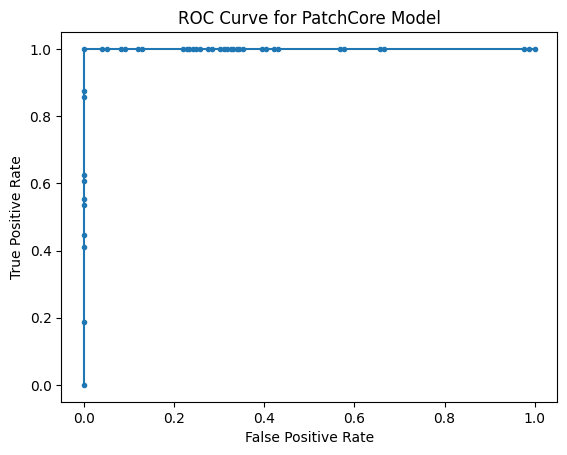

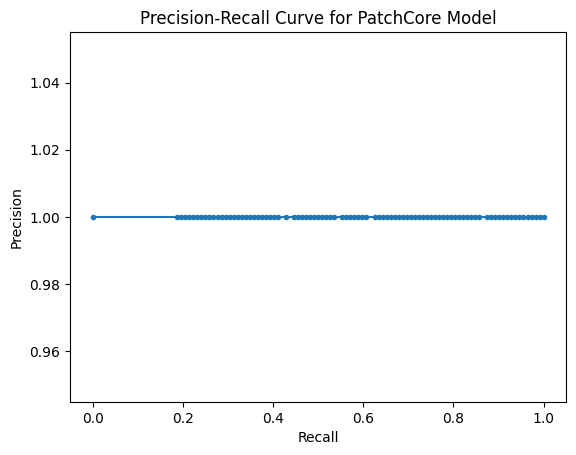

In [ ]:
# Import necessary modules
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score

# Create a new array of 0s and 1s
y_test = [1 if os.path.basename(path).startswith("a_") else 0 for path in test_image_paths]

# Define the threshold value
threshold = 0.65

# Calculate AUC-ROC (negate scores because lower scores indicate anomalies)
auc = roc_auc_score(y_test, prediction_scores)  # Use prediction_scores to reflect anomaly likelihood
print(f"AUC-ROC: {auc}")

# Calculate precision and recall metrics
precision_value = precision_score(y_test, [1 if score >= threshold else 0 for score in prediction_scores])
recall_value = recall_score(y_test, [1 if score >= threshold else 0 for score in prediction_scores])
print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, prediction_scores)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for PaDiM Model')
plt.show()


# Measure Latency

In [19]:
import glob
import time
from anomalib.data.utils import read_image


# Get a list of all image paths in the directory
test_image_paths = glob.glob(test_image_directory)


# Create an empty list to store prediction scores and inference times
prediction_scores = []
inference_times = []

# Iterate over each image and run the model predictions
for image_path in test_image_paths:
    #print(f"Processing image: {image_path}")  # Debugging print

    # Read the image
    image = read_image(path=image_path)
    
    # Measure the inference start time
    start_time = time.time()
    
    # Run predictions using the inferencer
    predictions = inferencer.predict(image=image)
    
    # Measure the inference end time
    end_time = time.time()
    
    # Calculate the inference time and add to the list
    inference_time = end_time - start_time
    inference_times.append(inference_time)
    
    # Extract prediction score
    score = predictions.pred_score
    
    # Append the score to the list
    prediction_scores.append(score)

    

# Calculate and print the mean inference time for the all images
mean_inference_time = (sum(inference_times) / len(inference_times)) * 1000 #convet to ms
print(f"Mean Inference Time for all images: {mean_inference_time:.4f} ms")

Mean Inference Time for all images: 7.3780 ms
